In [ ]:
import h5py
import glob
import os
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import cooler
import umap
from itertools import cycle, islice

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import LogNorm
from matplotlib import cm as cm
import cooltools.lib.plotting

from scipy import ndimage as nd
from scipy.stats import pearsonr
from scipy.signal import find_peaks
from sklearn.decomposition import PCA
from statsmodels.sandbox.stats.multicomp import multipletests as FDR
from concurrent.futures import ProcessPoolExecutor, as_completed

## Prepare pseudobulk analysis

In [11]:
def prepare_dir(output_dir, chunk_df, template, params):

    os.makedirs(output_dir, exist_ok=True)
    cell_table_path = f'{output_dir}cell_table.csv'
    chunk_df.to_csv(cell_table_path, header=False, index=True)
    params_str = '\n'.join(f'{k} = {v}' for k, v in params.items())

    with open(f'{output_dir}Snakefile_master', 'w') as f:
        f.write(params_str + template)
    return

In [10]:
cell_table = pd.read_csv("../phc_imputation/hicluster/imputed_matrix/100kb_resolution/filelist/cell_table.tsv", sep = '\t', index_col=0, names = ['cool_path'])
anno = pd.read_csv("FC_phc_HiC_240101_DPT_anno_cluster.info.txt", sep = '\t')
anno['bc'] = anno['library'] + '_mm10.sc_filt1k_' + anno['barcode'] + '.cool'
cell_table = cell_table.merge(anno, left_index=True, right_on='bc', how = 'inner')
cell_table.index = cell_table['bc']
cell_table = cell_table[['cool_path', 'cluster']]

cell_table.head()

,cool_path,cluster
bc,,
LC464_mm10.sc_filt1k_AAACAAGCATCAGTTC.cool,/projects/ps-renlab2/y2xie/projects/77.LC/39.P...,ITL23GL
LC464_mm10.sc_filt1k_AAACCGCCACAAACGC.cool,/projects/ps-renlab2/y2xie/projects/77.LC/39.P...,CTGL
LC464_mm10.sc_filt1k_AAACCGGTCGGTTAGG.cool,/projects/ps-renlab2/y2xie/projects/77.LC/39.P...,OPC
LC464_mm10.sc_filt1k_AAACGAACATTGTTTG.cool,/projects/ps-renlab2/y2xie/projects/77.LC/39.P...,SSTGA
LC464_mm10.sc_filt1k_AAACGGTTCAGGAGGG.cool,/projects/ps-renlab2/y2xie/projects/77.LC/39.P...,ASC


In [15]:
### Merge imputed matrices
### 240101: use DPT coembedding results
res = 100
outdir = f"/projects/ps-renlab2/y2xie/projects/77.LC/39.Paired_HiC_NovaSeq_230125/phc_imputation/hicluster/imputed_matrix/{res}kb_resolution/mcool/DPT/"
cell_cool = cell_table

clus = 'cluster'

for cluster, sub_df in cell_cool.groupby(clus):
    os.makedirs(f'{outdir}/{cluster}', exist_ok=True)
    sub_df.to_csv(f'{outdir}/{cluster}/cell_table.csv', header=False, index=True)
    print(cluster, sub_df.shape[0])

params = {
    'resolution': res*1000,
    'chrom_size_path': '"/projects/ps-renlab2/y2xie/projects/genome_ref/mm10.euchrom.sizes"',
}

PACKAGE_DIR = "/projects/ps-renlab2/y2xie/packages/scHiCluster/schicluster"
chunk_size = 500
total_chunk_dirs = []
group_chunks = {}

with open(f'{PACKAGE_DIR}/cool/Snakefile_chunk_template') as tmp:
    GENERATE_MATRIX_CHUNK_TEMPLATE = tmp.read()

for group, group_df in cell_cool.groupby(clus):
    group_chunks[group] = []
    if group_df.shape[0] <= chunk_size:
        this_dir = f'{outdir}/{group}_chunk0/'
        params['cell_table_path'] = f'"{this_dir}/cell_table.csv"'
        prepare_dir(this_dir, group_df, GENERATE_MATRIX_CHUNK_TEMPLATE, params)
        total_chunk_dirs.append(this_dir)
        group_chunks[group].append(this_dir)
    else:
        group_df['chunk'] = [i // chunk_size for i in range(group_df.shape[0])]
        for chunk, chunk_df in group_df.groupby('chunk'):
            this_dir = f'{outdir}/{group}_chunk{chunk}/'
            params['cell_table_path'] = f'"{this_dir}/cell_table.csv"'
            prepare_dir(this_dir, chunk_df, GENERATE_MATRIX_CHUNK_TEMPLATE, params)
            total_chunk_dirs.append(this_dir)
            group_chunks[group].append(this_dir)

            
with open(f'{outdir}/snakemake_cmd_step1.txt', 'w') as f:
    for chunk_dir in total_chunk_dirs:
        cmd = f'snakemake -d {chunk_dir}/ --snakefile {chunk_dir}/Snakefile_master -j 5 --rerun-incomplete'
        f.write(cmd + '\n')
params.pop('cell_table_path')
params_str = '\n'.join(f'{k} = {v}' for k, v in params.items())

with open(f'{PACKAGE_DIR}/cool/Snakefile_group_template') as tmp:
    GENERATE_MATRIX_GROUP_TEMPLATE = tmp.read()

with open(f'{outdir}/Snakefile', 'w') as f:
    f.write(params_str + '\n' + GENERATE_MATRIX_GROUP_TEMPLATE)
    
with open(f'{outdir}snakemake_cmd_step2.txt', 'w') as f:
    cmd = f'snakemake -d {outdir}/ --snakefile {outdir}/Snakefile -j 10 --rerun-incomplete'
    f.write(cmd + '\n')

ASC 154
CLAGL 158
CTGL 981
D12MSN 5
ITL23GL 1972
ITL45GL 1258
ITL5GL 694
ITL6GL 492
MGL 15
NPGL 269
OBGA 1
OBGL 26
OGC 142
OPC 315
PTGL 499
PVGA 507
SSTGA 418
STRGA 3
VIPGA 455
VLMC 11


In [16]:
chrom_size_path = '/projects/ps-renlab2/y2xie/projects/genome_ref/mm10.main.chrom.sizes'
chrom_sizes = cooler.read_chromsizes(chrom_size_path, all_names=True)
chrom_sizes = chrom_sizes.iloc[:19]

cpg = pd.read_hdf('/projects/ps-renlab2/y2xie/packages/scHiCluster/cpg/mm10_cpg_ratio_100k.hdf')

In [30]:
### Borrow schic data for transformation
pcall = np.load("../04.matrices/FC_schic_230601/LC462_bulk_comp_raw_all.npy", allow_pickle = True)
modelall = np.load("../04.matrices/FC_schic_230601/LC462_bulk_model_all.npy", allow_pickle = True)
binall = np.load("../04.matrices/FC_schic_230601/LC462_binfilter.npy", allow_pickle = True)

## Paired-HiC impute matrices

In [22]:
ipath = "/projects/ps-renlab2/y2xie/projects/77.LC/39.Paired_HiC_NovaSeq_230125/phc_imputation/hicluster/imputed_matrix/100kb_resolution/mcool/DPT/"
file_pattern = "*_chunk0"
file_list = glob.glob(os.path.join(ipath, file_pattern))
leg = [os.path.splitext(os.path.basename(file))[0].split("_")[0] for file in file_list]
print(leg)

mode = 'impute'
res = 100000

['OGC', 'OPC', 'ITL23GL', 'MGL', 'CLAGL', 'ASC', 'STRGA', 'OBGA', 'NPGL', 'ITL45GL', 'PTGL', 'ITL6GL', 'PVGA', 'OBGL', 'VLMC', 'VIPGA', 'ITL5GL', 'D12MSN', 'SSTGA', 'CTGL']


In [38]:
sad = np.zeros((len(leg),50,50))
count = np.zeros((len(leg),50,50))
comp = []

cpu = 8
with ProcessPoolExecutor(cpu) as executor:
    futures = {}
    for t,ct in enumerate(leg):
        if mode=='impute':
            cool = cooler.Cooler(f'{ipath}{ct}/{ct}.Q.cool')
        elif mode=='raw':
            cool = cooler.Cooler(f'{ipath}/{ct}.mcool::resolutions/100000')
        future = executor.submit(
            compsaddle,
            cool=cool,
        )
        futures[future] = t

    for future in as_completed(futures):
        t = futures[future]
        ct = leg[t]
        xx, yy, zz = future.result()
        comp.append(pd.Series(xx, name=ct))
        sad[t] += yy
        count[t] += zz
        print(f'{ct} finished')
        
bins_df = cool.bins()[:]
bins_df.index = bins_df['chrom'].astype(str) + '-' + (bins_df['start'] // res).astype(str)
compidx = np.concatenate([bins_df.index[bins_df['chrom']==c][binall[i]] for i,c in enumerate(chrom_sizes.index[:-1])])

comp = pd.concat(comp, axis=1)
comp.index = compidx

### normalize
sad = sad / count

OBGA finished
MGL finished
STRGA finished
OGC finished
ASC finished
OPC finished
CLAGL finished
ITL23GL finished
VLMC finished
NPGL finished
OBGL finished
ITL6GL finished
PVGA finished
PTGL finished
ITL45GL finished
VIPGA finished
D12MSN finished
SSTGA finished
CTGL finished
ITL5GL finished


In [39]:
odir = "/projects/ps-renlab2/y2xie/projects/77.LC/39.Paired_HiC_NovaSeq_230125/04.matrices/FC_phc_240101/"
comp.to_hdf(f'{odir}/compartment/comp_{mode}_LC462_raw_pca.hdf', key='data')
np.save(f'{odir}/compartment/saddle_{mode}_LC462_raw_pca.npy', sad)

## Plot examples of compartment across clusters (Fig.6C)

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 21 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'C', 'G', 'I', 'L', 'O', 'P', 'T', 'V', 'eight', 'five', 'four', 'minus', 'nonmarkingreturn', 'one', 'six', 'space', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 23, 24, 25, 27, 36, 38, 42, 44, 47, 50, 51, 55, 57, 3228]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 21 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'C', 'G', 'I', 'L', 'O', 'P', 'T', 'V', 'eight', 'five', 'four', 'minus', 'nonmar

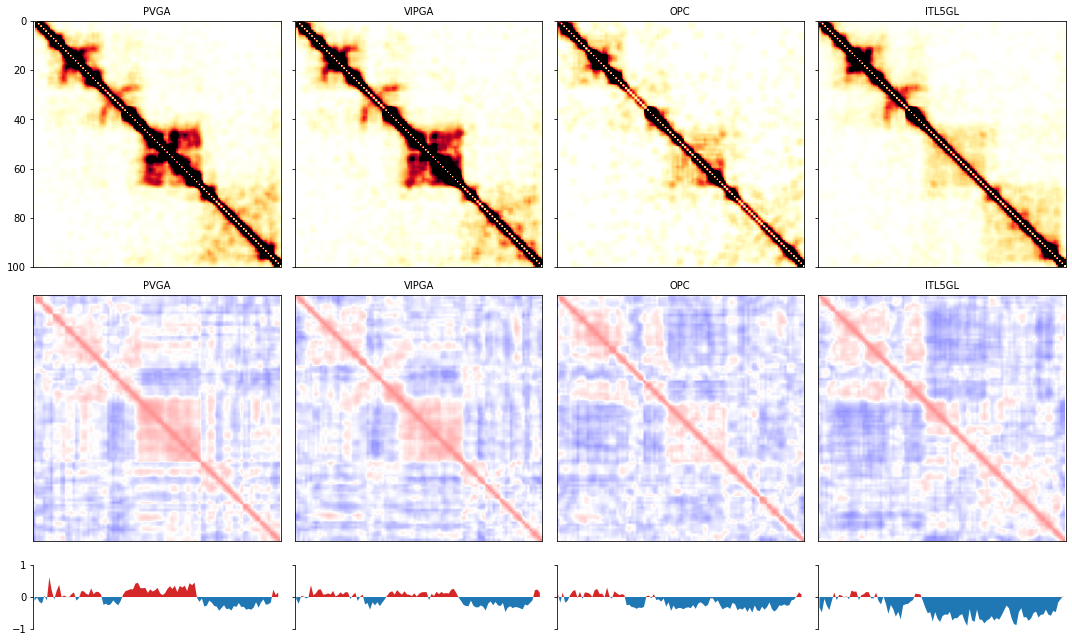

In [146]:
ipath = "/projects/ps-renlab2/y2xie/projects/77.LC/39.Paired_HiC_NovaSeq_230125/phc_imputation/hicluster/imputed_matrix/100kb_resolution/mcool/DPT/"
comp = pd.read_hdf("../../39.Paired_HiC_NovaSeq_230125/04.matrices/FC_phc_240101/compartment/comp_raw_LC462_raw_pca.hdf")

leg = ['PVGA', 'VIPGA', 'OPC', 'ITL5GL']

nchr = 1
chrom = f'chr{nchr}'
res = 100_000
ll, rr = 625, 725 ### Erbb4
n_bins = (int(chrom_sizes.loc[chrom]) // res + 1)
Qall = []
Call = []
pcall = []

fig, axes = plt.subplots(3, 4, figsize=(15, 9), 
                         gridspec_kw={'height_ratios':[2, 2, 0.5]}, sharex='col', sharey='row')

for k, ct in enumerate(leg):
    # binfilter = binall[nchr-1]
    
    cool = cooler.Cooler(f'{ipath}/{ct}/{ct}.Q.cool::/')
    Q = cool.matrix(balance=False, sparse=True).fetch(chrom).toarray()
    Q = Q - np.diag(np.diag(Q))
    Q = Q[ll:rr, ll:rr]
    Qall.append(Q)
    decay = np.array([np.mean(np.diag(Q, i)) for i in range(Q.shape[0])])
    E = np.zeros(Q.shape)
    row, col = np.diag_indices(E.shape[0])
    E[row, col] = 1
    for i in range(1, E.shape[0]):
        E[row[:-i], col[i:]] = (Q[row[:-i], col[i:]] + 1e-5) / (decay[i] + 1e-5)
    E = E + E.T
    C = np.corrcoef(np.log2(E + 0.001))
    Call.append(C)
    
    ax = axes[0, k]
    ax.imshow(Q, cmap = 'fall', vmax = 0.015, extent = [0, rr-ll, rr-ll, 0])
    ax.set_title(ct, fontsize=10)
    
    ax = axes[1, k]
    ax.imshow(C, cmap='bwr', vmin = -1.5, vmax = 2)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(ct, fontsize=10)
    
    ax = axes[2, k]
    sns.despine(bottom=True, ax=ax)
    tmp = comp.loc[(comp.index.str.split('-').str[0] == chrom) & (comp.index.str.split('-').str[1].astype(int) >= ll) & (comp.index.str.split('-').str[1].astype(int) < rr), ct]
    tmp.index = [int(xx.split('-')[1]) for xx in tmp.index]
    pcall.append(tmp)#.iloc[np.where(binfilter)[0]].values)
    # tmp = np.zeros(n_bins)
    # tmp[binfilter] = pcall[k]
    x, y = np.arange(len(pcall[k])), pcall[k]
    ax.fill_between(x, y, 0, where=y >= 0, facecolor='C3', interpolate=True)
    ax.fill_between(x, y, 0, where=y <= 0, facecolor='C0', interpolate=True)
    ax.set_ylim([-1, 1])

plt.tight_layout()
plt.savefig(f'FC_phc_HiC_240101_raw_comp_{nchr}_{ll}_{rr}.pdf')